In [1]:
import earthkit.hydro as ekh
import numpy as np
import matplotlib.pyplot as plt
import earthkit.data as ekd
import earthkit.plots as ekp
import earthkit.plots.quickplot as qplot

# River Network Creation

In [ ]:
network = ekh.load_river_network(domain="efas", version="5")

caching in /etc/ecmwf/ssd/ssd1/tmpdirs/ecm7348.652446.20241114_103336.067/tmpk2mr9wow_earthkit_hydro


# Accuflux

In [11]:
# create or load a field of interest e.g. area, precipitation, discharge
# as an example, we provide a unit field over the domain
field = np.ones(network.mask.shape)

In [12]:
# conduct an accuflux
# this finds the amount of cells flowing into each point
accuflux_field = network.accuflux(field)

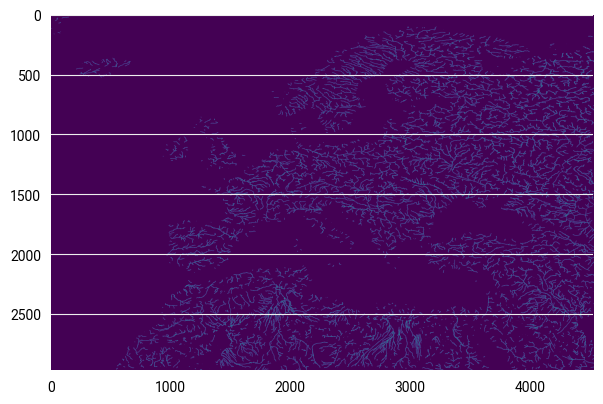

In [13]:
# visualise the results

# for example, to look at the rivers:
# create a field finding cells with more than e.g. 500 cells flowing into them
plt.imshow(accuflux_field > 500)
plt.show()

# Subcatchments & Catchments

In [6]:
# create or load the points of interest
points = np.zeros(network.mask.shape)
points[1801, 4529] = 3  # largest catchment's sink is at (1801, 4529)
points[886, 3999] = 2  # point within largest catchment but not the sink
points[1621, 3298] = 1  # separate catchment

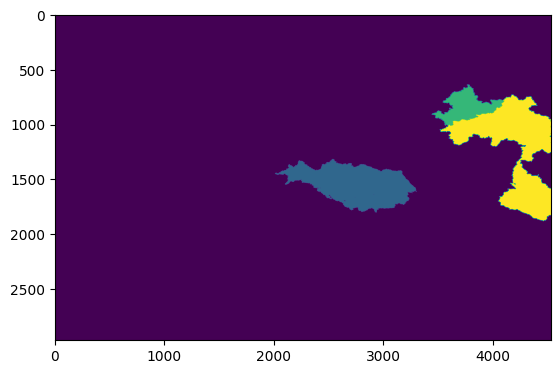

In [7]:
# find and plot the subcatchments
subcatchment_field = network.subcatchment(points)

plt.imshow(subcatchment_field)
plt.show()

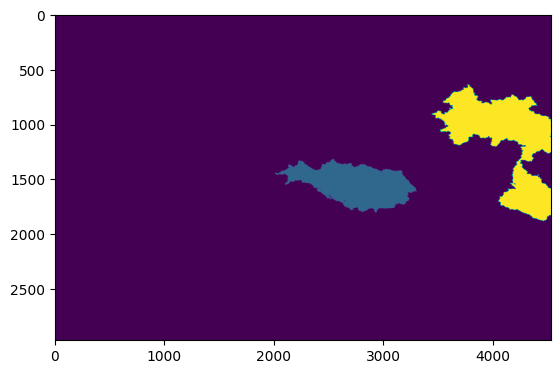

In [8]:
# find and plot the catchments
# note: the subcatchment has been overwritten
catchment_field = network.catchment(points)

plt.imshow(catchment_field)
plt.show()

# Upstream & Downstream

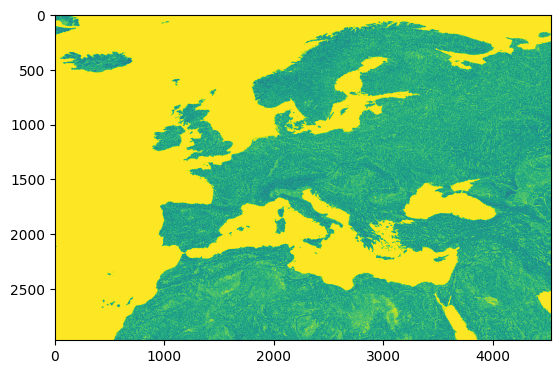

In [9]:
upstream_field = network.upstream(field)
plt.imshow(upstream_field > 0)  # show all cells with an upstream
plt.show()

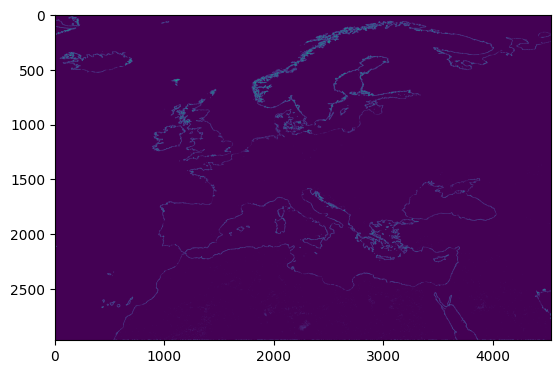

In [10]:
downstream_field = network.downstream(field)
plt.imshow(downstream_field == 0)  # show the sinks
plt.show()

# Subnetwork

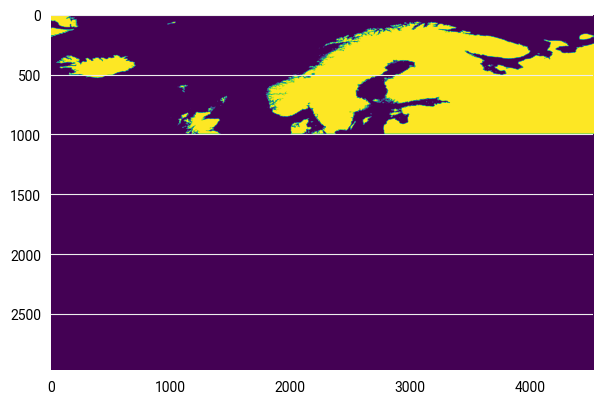

In [17]:
# create a subnetwork given a mask
# of northern Europe
mask = np.full(network.mask.shape, False)
mask[:1000] = True
subnetwork = network.create_subnetwork(mask)

plt.imshow(subnetwork.mask)
plt.show()

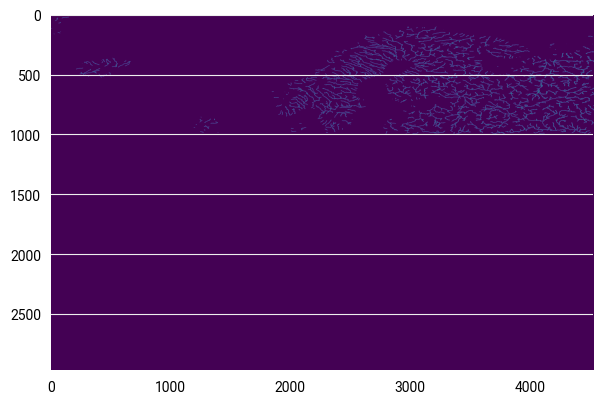

In [19]:
# conduct accuflux on the subnetwork
field = np.ones(network.mask.shape)
accuflux_field = subnetwork.accuflux(field)
plt.imshow(accuflux_field > 500)
plt.show()

# Example with Earthkit and Precipitation Maps

In [5]:
style = ekp.styles.Style(
    colors="Blues",
    levels=[0, 0.5, 1, 2, 5, 10, 50, 100, 500, 1000, 2000, 3000, 4000],
    extend="max",
)

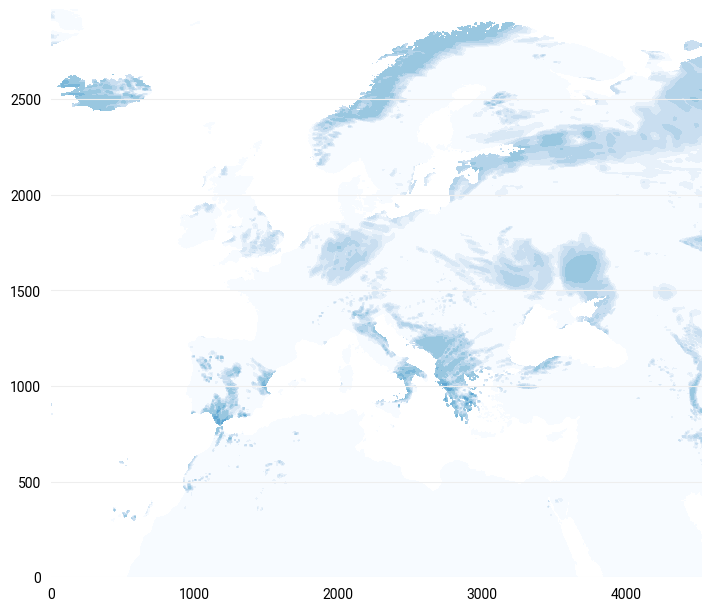

In [6]:
precipitation_field = ekd.from_source(
    "file", "/ec/ws4/tc/emos/work/cems/floods/efas/emos/efas/europe5km/202411/EUD2024111400/forcings/R06a.nc"
)[0].to_numpy()

qplot.contourf(precipitation_field[::-1, :], style=style)

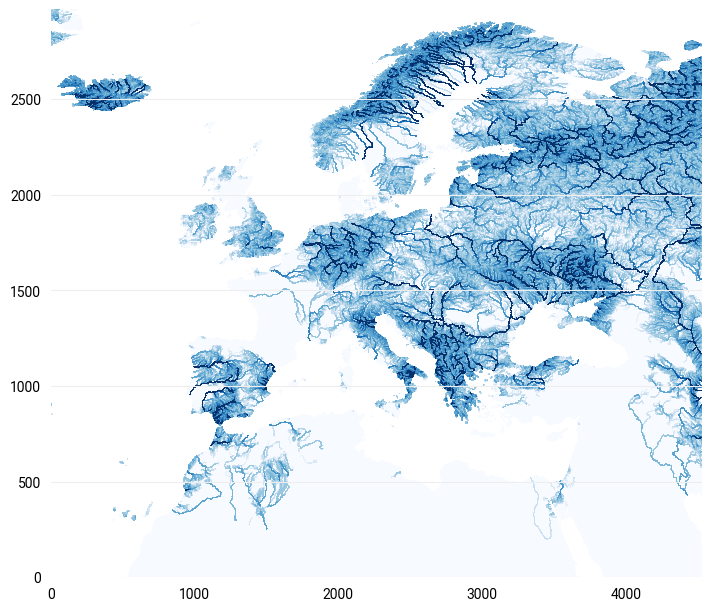

In [7]:
accuflux_field = network.accuflux(precipitation_field)
qplot.contourf(accuflux_field[::-1, :], style=style)